# カーネル法を用いたサポートベクターマシン

## 線形モデルと非線形特徴
下記のような例ではSVMで境界を引くことができない。

Text(0, 0.5, 'Feature 1')

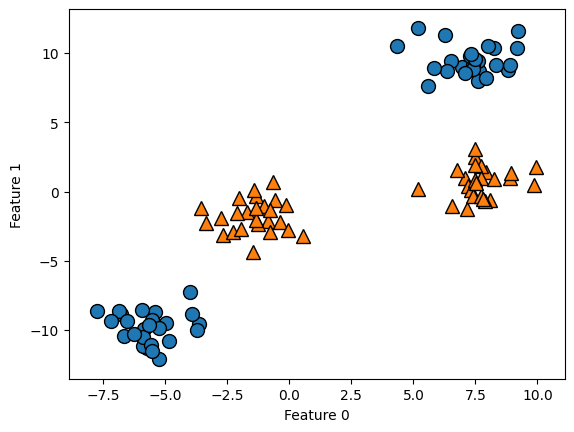

In [1]:
from sklearn.datasets import make_blobs
import mglearn
import matplotlib.pyplot as plt

X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

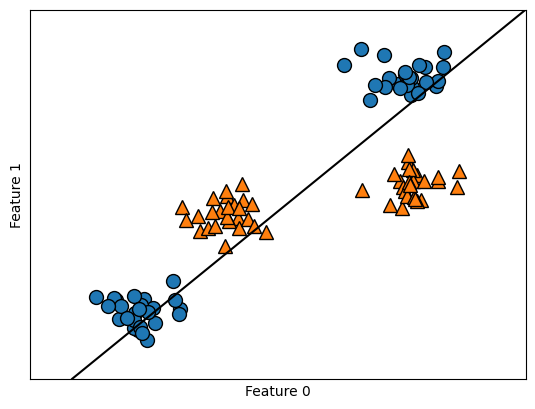

In [2]:
from sklearn.svm import LinearSVC
import mglearn

linear_svm = LinearSVC().fit(X, y)
mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

### ChatGPTに出してもらったカーネル関数についての解説

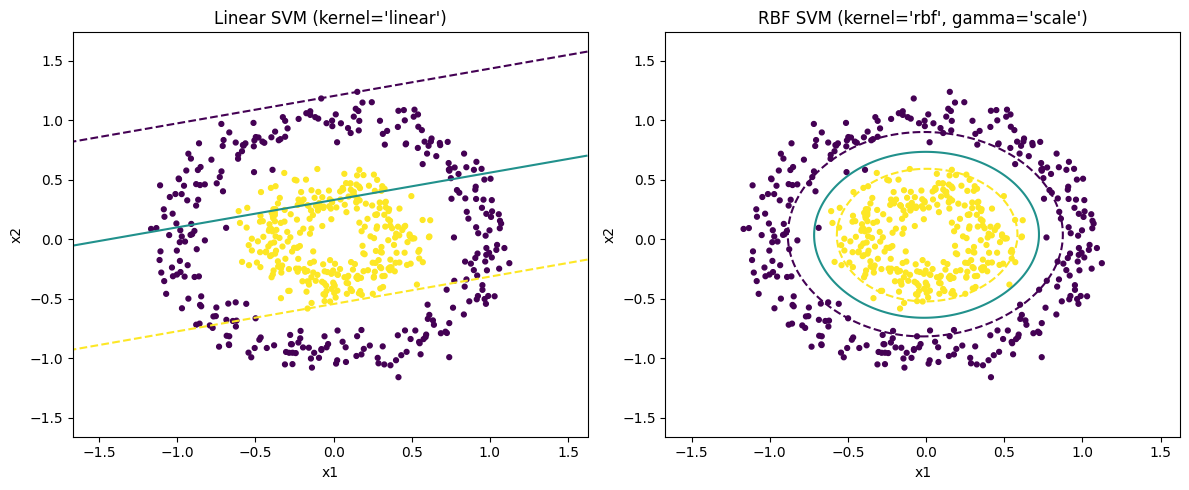

Train accuracy (Linear): 0.615
Train accuracy (RBF)   : 0.9966666666666667


In [3]:
# %%
# 円データを線形SVMとRBFカーネルSVMで分類して可視化
# ----------------------------------------------------
# 必要ライブラリ:
# pip install scikit-learn matplotlib numpy

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 1) データ生成（内円=+1, 外円=-1 のような円状データ）
X, y = make_circles(n_samples=600, factor=0.4, noise=0.1, random_state=42)

# 2) 2つのモデルを用意
#    - 線形SVM（カーネルなし）
#    - RBFカーネルSVM（非線形境界）
linear_svm = Pipeline(
    [("scaler", StandardScaler()), ("svc", SVC(kernel="linear", C=1.0))]
)

rbf_svm = Pipeline(
    [("scaler", StandardScaler()), ("svc", SVC(kernel="rbf", C=1.0, gamma="scale"))]
)

# 3) 学習
linear_svm.fit(X, y)
rbf_svm.fit(X, y)

# 4) 可視化用のグリッドを作成
x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx1, xx2 = np.meshgrid(
    np.linspace(x1_min, x1_max, 400), np.linspace(x2_min, x2_max, 400)
)
grid = np.c_[xx1.ravel(), xx2.ravel()]


# 5) 予測スコア（決定関数）をメッシュ上で計算
def decision_values(model, points):
    # SVCはdecision_functionが決定関数値、なければpredict_probaから擬似的に
    svc = model.named_steps["svc"]
    if hasattr(svc, "decision_function"):
        z = model.decision_function(points)
    else:
        z = model.predict_proba(points)[:, 1] * 2 - 1
    return z


Z_linear = decision_values(linear_svm, grid).reshape(xx1.shape)
Z_rbf = decision_values(rbf_svm, grid).reshape(xx1.shape)

# 6) 描画
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 左: 線形SVM
ax = axes[0]
# 決定境界(0)とマージン(±1)を等高線で描く
cs = ax.contour(xx1, xx2, Z_linear, levels=[-1, 0, 1], linestyles=["--", "-", "--"])
ax.scatter(X[:, 0], X[:, 1], c=y, s=12)  # データ点
ax.set_title("Linear SVM (kernel='linear')")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_xlim(x1_min, x1_max)
ax.set_ylim(x2_min, x2_max)

# 右: RBFカーネルSVM
ax = axes[1]
cs = ax.contour(xx1, xx2, Z_rbf, levels=[-1, 0, 1], linestyles=["--", "-", "--"])
ax.scatter(X[:, 0], X[:, 1], c=y, s=12)
ax.set_title("RBF SVM (kernel='rbf', gamma='scale')")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_xlim(x1_min, x1_max)
ax.set_ylim(x2_min, x2_max)

plt.tight_layout()
plt.show()

# 7) ざっくり精度表示
from sklearn.metrics import accuracy_score

print("Train accuracy (Linear):", accuracy_score(y, linear_svm.predict(X)))
print("Train accuracy (RBF)   :", accuracy_score(y, rbf_svm.predict(X)))

# %%
# ★ チューニングのヒント
# - C: 大きいほど訓練データの誤分類を許さない（境界が複雑に）。小さいほど滑らかな境界。
# - gamma（RBF用）: 大きいほど局所的に反応（細かい境界）、小さいほど広域に反応（滑らか）。
#   例) SVC(kernel="rbf", C=10, gamma=0.5) などを試してみてください。